In [1]:
import numpy as np
import qmt
import imt
import ring
from imt.utils.view import view
from imt.utils.view import VisOptions
import matplotlib.pyplot as plt
import tree

In [2]:
# LOAD DATA
file = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Dict_Frames/S0131_dict_frame.npy"  # noqa: E501
sensors = ["S0333", "S1094", "S0593", "S0994", "S0477"] # 5 Sensoren
#sensors = ["S1094", "S0593"]   # 2 Sensoren, nur Knie rechts
data = np.load(file, allow_pickle=True).item()
Hz = 52

In [3]:
# PREPARE DATA
imu_data = {
    i: dict(acc=data[sensors[i]]["acc"], gyr=data[sensors[i]]["gyr_rad"])
    for i in range(5)
    #for i in range(2)  # nur Knie rechts
}
imu_data = imt.utils.resample(imt.utils.crop_tail(imu_data, Hz), Hz, 100.0)
imu_data[0] = dict(
    acc=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["acc"]),
    gyr=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["gyr"]),
)       # 5 Sensoren

`crop_tail`: Crop off at t=182.15384615384616s


In [14]:
# ESTIMATE ORIENTATIONS
rel_method = imt.methods.RING(axes_directions=np.array([1.0, 0, 0]))
graph = [-1, 0, 1, 0, 3]
Ts=0.01
solver = imt.Solver(graph, [imt.methods.VQF(offline=True)] + 
                    #[imt.wrappers.JointTracker1D(imt.wrappers.LPF(imt.wrappers.JointPosition(imt.wrappers.FractualStepping(rel_method, 100), dof_is_1d=False), quat_f_cutoff=2))] * 4,
                    [imt.wrappers.JointTracker1D(imt.wrappers.JointPosition(rel_method, dof_is_1d=False))] * 4, 
                    Ts=Ts)
qhat, extras = solver.step(imu_data)

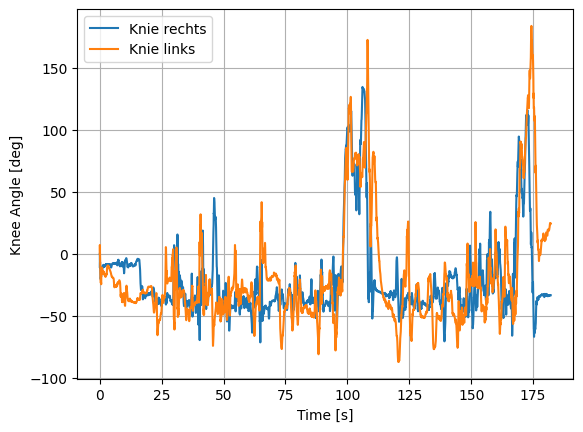

In [15]:
T = qhat[0].shape[0]
ts = np.arange(T)*Ts
#plt.plot(ts, np.rad2deg(extras[1]["joint_angle_rad"]), label="Hüfte rechts")
plt.plot(ts, np.rad2deg(extras[2]["joint_angle_rad"]), label="Knie rechts")
#plt.plot(ts, np.rad2deg(extras[1]["joint_angle_rad"]), label="Knie rechts")   # nur Knie rechts
#plt.plot(ts, np.rad2deg(extras[3]["joint_angle_rad"]), label="Hüfte links")
plt.plot(ts, np.rad2deg(extras[4]["joint_angle_rad"]), label="Knie links")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

In [20]:

extras[1]["joint-center-to-body1"] = np.array([-0.5, 0.15, 0])
extras[3]["joint-center-to-body1"] = np.array([0.05, 0.15, 0])
extras[1]["joint-center-to-body2"] = np.array([0, -0.05, -0.025])
extras[3]["joint-center-to-body2"] = np.array([0, -0.05, -0.025])
extras[2]["joint-center-to-body1"] = np.array([0, 0.05, 0])
extras[2]["joint-center-to-body2"] = np.array([0, -0.05, 0])
extras[4]["joint-center-to-body1"] = np.array([0, 0.05, 0])
extras[4]["joint-center-to-body2"] = np.array([0, -0.05, 0])

In [ ]:
# SHOW ANIMATION
#T = int(10 / Ts)           # show only the first 10 seconds
#pos = np.zeros((T, 3))     # show only the first 10 seconds
pos = np.zeros((qhat[0].shape[0], 3))
pos[:, 2] = 0.05

#qhat_first_10_seconds = tree.map_structure(lambda a: a[:T], qhat)      # show only the first 10 seconds
vis_options = VisOptions(
    show_floor=False,
    show_stars=False,
    body_xyz_dim=0.03,
    imu_xyz_dim=0.02,
    imu_type="cylinder",
    imu_dim="0.01 0.005",
    imu_color="black",
    #floor_material="beige",
    joint_to_imu_color=[0.5, 0.5, 0.5, 1],
    imu_offset=[0, 0, -0.01],
    show_imu_xyz=False,
)
view(graph,
     qhat, 
     #qhat_first_10_seconds,        # show only the first 10 seconds
     extras, 
     hz=100, 
     global_translation=pos, 
     mode="offscreen",
     width=640, 
     height=480, 
     offscreen_mode_options=dict(camid=1, github=True),# output_path="C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/videoSimS0131.gif"), 
     show_every_nth_frame=4,
     vis_options=vis_options,
     )